In [ ]:
%%capture
!pip install simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import os
import json
import math
import random
import pandas as pd
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, fbeta_score, precision_recall_fscore_support

In [ ]:
# Custom classification report function with F0.5 score (modify sklearn's classification_report)

from sklearn.metrics import precision_score, recall_score, fbeta_score, precision_recall_fscore_support
from sklearn.utils import _unique
from sklearn.metrics import _classification
from sklearn.utils import multiclass
import warnings
import numpy as np
from numbers import Integral, Real
from sklearn.utils._param_validation import (
    Hidden,
    Interval,
    Options,
    StrOptions,
    validate_params,
)

@validate_params(
    {
        "y_true": ["array-like", "sparse matrix"],
        "y_pred": ["array-like", "sparse matrix"],
        "labels": ["array-like", None],
        "target_names": ["array-like", None],
        "sample_weight": ["array-like", None],
        "digits": [Interval(Integral, 0, None, closed="left")],
        "output_dict": ["boolean"],
        "zero_division": [
            Options(Real, {0.0, 1.0}),
            "nan",
            StrOptions({"warn"}),
        ],
    },
    prefer_skip_nested_validation=True,
)
def classification_report_f0_5(
    y_true,
    y_pred,
    *,
    labels=None,
    target_names=None,
    sample_weight=None,
    digits=2,
    output_dict=False,
    zero_division="warn",
):
    """Build a text report showing the main classification metrics.

    Read more in the :ref:`User Guide <classification_report>`.

    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.

    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.

    labels : array-like of shape (n_labels,), default=None
        Optional list of label indices to include in the report.

    target_names : array-like of shape (n_labels,), default=None
        Optional display names matching the labels (same order).

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.

    digits : int, default=2
        Number of digits for formatting output floating point values.
        When ``output_dict`` is ``True``, this will be ignored and the
        returned values will not be rounded.

    output_dict : bool, default=False
        If True, return output as dict.

        .. versionadded:: 0.20

    zero_division : {"warn", 0.0, 1.0, np.nan}, default="warn"
        Sets the value to return when there is a zero division. If set to
        "warn", this acts as 0, but warnings are also raised.

        .. versionadded:: 1.3
           `np.nan` option was added.

    Returns
    -------
    report : str or dict
        Text summary of the precision, recall, F1 score for each class.
        Dictionary returned if output_dict is True. Dictionary has the
        following structure::

            {'label 1': {'precision':0.5,
                         'recall':1.0,
                         'f1-score':0.67,
                         'support':1},
             'label 2': { ... },
              ...
            }

        The reported averages include macro average (averaging the unweighted
        mean per label), weighted average (averaging the support-weighted mean
        per label), and sample average (only for multilabel classification).
        Micro average (averaging the total true positives, false negatives and
        false positives) is only shown for multi-label or multi-class
        with a subset of classes, because it corresponds to accuracy
        otherwise and would be the same for all metrics.
        See also :func:`precision_recall_fscore_support` for more details
        on averages.

        Note that in binary classification, recall of the positive class
        is also known as "sensitivity"; recall of the negative class is
        "specificity".

    See Also
    --------
    precision_recall_fscore_support: Compute precision, recall, F-measure and
        support for each class.
    confusion_matrix: Compute confusion matrix to evaluate the accuracy of a
        classification.
    multilabel_confusion_matrix: Compute a confusion matrix for each class or sample.

    Examples
    --------
    >>> from sklearn.metrics import classification_report
    >>> y_true = [0, 1, 2, 2, 2]
    >>> y_pred = [0, 0, 2, 2, 1]
    >>> target_names = ['class 0', 'class 1', 'class 2']
    >>> print(classification_report(y_true, y_pred, target_names=target_names))
                  precision    recall  f1-score   support
    <BLANKLINE>
         class 0       0.50      1.00      0.67         1
         class 1       0.00      0.00      0.00         1
         class 2       1.00      0.67      0.80         3
    <BLANKLINE>
        accuracy                           0.60         5
       macro avg       0.50      0.56      0.49         5
    weighted avg       0.70      0.60      0.61         5
    <BLANKLINE>
    >>> y_pred = [1, 1, 0]
    >>> y_true = [1, 1, 1]
    >>> print(classification_report(y_true, y_pred, labels=[1, 2, 3]))
                  precision    recall  f1-score   support
    <BLANKLINE>
               1       1.00      0.67      0.80         3
               2       0.00      0.00      0.00         0
               3       0.00      0.00      0.00         0
    <BLANKLINE>
       micro avg       1.00      0.67      0.80         3
       macro avg       0.33      0.22      0.27         3
    weighted avg       1.00      0.67      0.80         3
    <BLANKLINE>
    """

    y_true, y_pred = _unique.attach_unique(y_true, y_pred)
    y_type, y_true, y_pred = _classification._check_targets(y_true, y_pred)

    if labels is None:
        labels = multiclass.unique_labels(y_true, y_pred)
        labels_given = False
    else:
        labels = np.asarray(labels)
        labels_given = True

    # labelled micro average
    micro_is_accuracy = (y_type == "multiclass" or y_type == "binary") and (
        not labels_given or (set(labels) >= set(multiclass.unique_labels(y_true, y_pred)))
    )

    if target_names is not None and len(labels) != len(target_names):
        if labels_given:
            warnings.warn(
                "labels size, {0}, does not match size of target_names, {1}".format(
                    len(labels), len(target_names)
                )
            )
        else:
            raise ValueError(
                "Number of classes, {0}, does not match size of "
                "target_names, {1}. Try specifying the labels "
                "parameter".format(len(labels), len(target_names))
            )
    if target_names is None:
        target_names = ["%s" % l for l in labels]

    headers = ["precision", "recall", "f0.5-score", "support"]
    # compute per-class results without averaging
    p, r, f1, s = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=labels,
        beta=0.5,
        average=None,
        sample_weight=sample_weight,
        zero_division=zero_division,
    )
    rows = zip(target_names, p, r, f1, s)

    if y_type.startswith("multilabel"):
        average_options = ("micro", "macro", "weighted", "samples")
    else:
        average_options = ("micro", "macro", "weighted")

    if output_dict:
        report_dict = {label[0]: label[1:] for label in rows}
        for label, scores in report_dict.items():
            report_dict[label] = dict(zip(headers, [float(i) for i in scores]))
    else:
        longest_last_line_heading = "weighted avg"
        name_width = max(len(cn) for cn in target_names)
        width = max(name_width, len(longest_last_line_heading), digits)
        head_fmt = "{:>{width}s} " + " {:>9}" * len(headers)
        report = head_fmt.format("", *headers, width=width)
        report += "\n\n"
        row_fmt = "{:>{width}s} " + " {:>9.{digits}f}" * 3 + " {:>9}\n"
        for row in rows:
            report += row_fmt.format(*row, width=width, digits=digits)
        report += "\n"

    # compute all applicable averages
    for average in average_options:
        if average.startswith("micro") and micro_is_accuracy:
            line_heading = "accuracy"
        else:
            line_heading = average + " avg"

        # compute averages with specified averaging method
        avg_p, avg_r, avg_f1, _ = precision_recall_fscore_support(
            y_true,
            y_pred,
            labels=labels,
            beta=0.5,
            average=average,
            sample_weight=sample_weight,
            zero_division=zero_division,
        )
        avg = [avg_p, avg_r, avg_f1, np.sum(s)]

        if output_dict:
            report_dict[line_heading] = dict(zip(headers, [float(i) for i in avg]))
        else:
            if line_heading == "accuracy":
                row_fmt_accuracy = (
                    "{:>{width}s} "
                    + " {:>9.{digits}}" * 2
                    + " {:>9.{digits}f}"
                    + " {:>9}\n"
                )
                report += row_fmt_accuracy.format(
                    line_heading, "", "", *avg[2:], width=width, digits=digits
                )
            else:
                report += row_fmt.format(line_heading, *avg, width=width, digits=digits)

    if output_dict:
        if "accuracy" in report_dict.keys():
            report_dict["accuracy"] = report_dict["accuracy"]["precision"]
        return report_dict
    else:
        return report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# I used 'provide_confusion_matrix' , 'calculate_precision_recall_f1score' , 'evaluation_model' functions from previous term
def provide_confusion_matrix(GoldLabel, PredictLabel, label_set):
    """
    use `sklearn.metric confusion_matrix` to create confusion matrix of model predict.
    and `sklearn.metric ConfusionMatrixDisplay` to display created confusion matrix.

    Parameters
    ----------
    GoldLabel : list
        list of all Gold labels
    PredictLabel : list
        list of all Prediction labels
    label_set : list
        list of all classes

    Returns
    -------
        Confusion matrix
    """
    print(label_set)
    cf_matrix = confusion_matrix(GoldLabel, PredictLabel) # create a confusion matrix with gold and predicts
    print(cf_matrix) # print confusion_matrix as text
    display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_set) # create graphical confusion_matrix
    fig, ax = plt.subplots()# figsize=(15,15)) # create bigger plot because there is many classes in this task
    display.plot(ax =ax) # show confusion_matrix
    plt.xticks(rotation=90) # rotate X label of plot 90 degree
    plt.show() # show confusion matrix
    return cf_matrix # return confusion_matrix (maybe useful later)

def calculate_precision_recall_f05score(GoldLabel, PredictLabel, label_set): # function get gold and predict and set of labels
    """
    use `sklearn.metric classification_report` to get report of model predict.

    Parameters
    ----------
    GoldLabel : list
        list of all Gold labels
    PredictLabel : list
        list of all Prediction labels
    label_set : list
        list of all classes

    Returns
    -------
        Classification report
    """
    print(label_set)
    report = classification_report_f0_5(GoldLabel, PredictLabel, digits = 3, target_names=label_set) # calculate report
    print(report) # print report
    return report # return report (maybe useful later)


def fine_tune_eval(GoldLabel, PredictLabel, target_names): # get gold and predict
    """
    Evaluation models by call `calculate_precision_recall_f1score` and `provide_confusion_matrix` functions.

    Parameters
    ----------
    data :
        Train or test or dev dataset (after extracting fetures)
    PredictLabel : list
        list of all Prediction labels

    Returns
    -------
        Classification report and Confusion matrix
    """
    # set(list(preds_hp_2_1)+test_data_gold)
    label_set = target_names
    # label_set = sorted(set(list(PredictLabel) + GoldLabel)) # find unique lables in gold

    print(label_set)

    print('precision_recall_f1-score')
    report = calculate_precision_recall_f05score(GoldLabel, PredictLabel, label_set) # calculate_precision_recall_f1score

    print('Confusion matrix')
    cf_matrix = provide_confusion_matrix(GoldLabel, PredictLabel, label_set) # provide_confusion_matrix

    return report, cf_matrix # return report and cf_matrix


In [ ]:
def predict_model(model_path, test_data):
  """
  Predicts labels for the test data using a pre-trained model.
  Args:
	model_path (str): Path to the pre-trained model.
	test_data (list): List of test data instances.
  Returns:
	predictions (list): List of predicted labels.
	raw_outputs (list): List of raw output scores from the model.
  """
  model = ClassificationModel('roberta', model_path)
  predictions, raw_outputs = model.predict(test_data)

  return predictions, raw_outputs


In [ ]:
def save_model_preds(test_data, model_preds, model_prob, save_path, model_name):
  """
  Saves test data with model predictions and probabilities to a CSV file.
  Args:
	test_data (DataFrame): DataFrame containing the test data.
	model_preds (list): List of predicted labels.
	model_prob (list): List of model probabilities for each class.
	save_path (str): Path to save the output CSV file.
	model_name (str): Name of the model for the output file.
  Returns:
	out_data (DataFrame): DataFrame containing the test data with predictions and probabilities.
  """
  out_data = test_data.copy()
  out_data['prediction']=model_preds
  list_of_model_prob = [arr.tolist() for arr in model_prob]
  dict_of_model_prob = [{'G':probs[0], 'PREP':probs[1], 'DET':probs[2], 'SVA':probs[3]} for probs in list_of_model_prob]
    # Add the list of lists as a new column to the DataFrame
    # df['new_column'] = list_of_lists
  out_data['Probabilities']=dict_of_model_prob
  out_data.to_csv(os.path.join(save_path, f"outfile_prob_{model_name}.csv"), index=False)
  return out_data

In [ ]:
outfile_path = "/content/drive/MyDrive/VU Thesis/Code/Error_Analysis/outfiles_with_prob"
data_path = "/content/drive/MyDrive/VU Thesis/Code/fine_tune/data"


In [ ]:
print("loading data...")

print("loading train_data.csv")
train_df =pd.read_csv(os.path.join(data_path, "train_data.csv"))

print("loading dev_data.csv")
dev_df =pd.read_csv(os.path.join(data_path, "dev_data.csv"))

print("loading test_data.csv")
test_df =pd.read_csv(os.path.join(data_path, "test_data.csv"))

print("loading data compelete.")

loading data...
loading train_data.csv
loading dev_data.csv
loading test_data.csv
loading data compelete.


In [ ]:
test_data = list(test_df.text)#.to_list()
gold_labels = list(test_df.labels)#.to_list()
print(len(test_data), len(gold_labels))

6988 6988


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.993     1.000     0.994      1508
           G      0.922     0.827     0.901      3494
        PREP      0.557     0.787     0.591       879
         SVA      0.960     0.946     0.957      1107

    accuracy                          0.878      6988
   macro avg      0.858     0.890     0.861      6988
weighted avg      0.897     0.878     0.891      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [  10 2890  551   43]
 [   0  186  692    1]
 [   1   59    0 1047]]


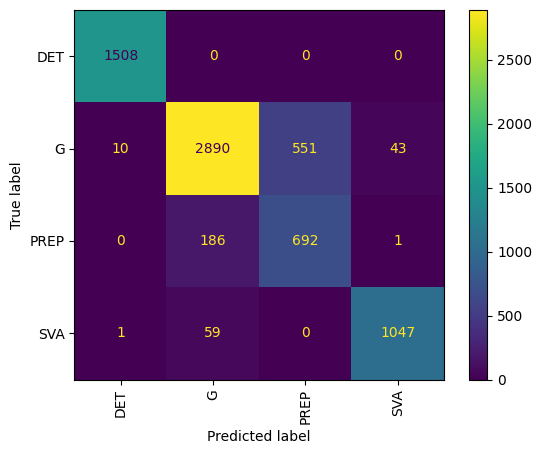

In [ ]:
model_e9_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_v20_l4_e9_model'

preds_e9, probs_e9 = predict_model(model_e9_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_e9, cf_matrix_e9 = fine_tune_eval(gold_labels, preds_e9, target_names)
df_e9 = save_model_preds(test_df, preds_e9, probs_e9, outfile_path, 'v20_l4_e9')

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.999     1.000     0.999      1508
           G      0.905     0.939     0.911      3494
        PREP      0.722     0.617     0.698       879
         SVA      0.995     0.992     0.995      1107

    accuracy                          0.920      6988
   macro avg      0.905     0.887     0.901      6988
weighted avg      0.917     0.920     0.917      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   1 3280  209    4]
 [   0  336  542    1]
 [   0    9    0 1098]]


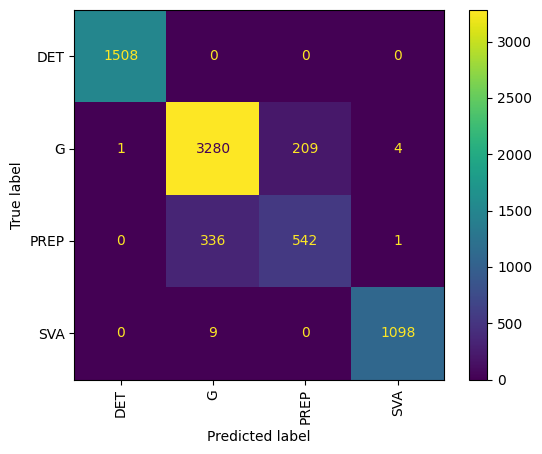

In [ ]:
model_o_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_O_RoBERTa_model'

preds_o, probs_o = predict_model(model_o_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_o, cf_matrix_o = fine_tune_eval(gold_labels, preds_o, target_names)
df_o = save_model_preds(test_df, preds_o, probs_o, outfile_path, 'o_RoBERTa')


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.999     1.000     0.999      1508
           G      0.915     0.845     0.900      3494
        PREP      0.538     0.702     0.565       879
         SVA      0.985     0.986     0.985      1107

    accuracy                          0.883      6988
   macro avg      0.859     0.883     0.862      6988
weighted avg      0.897     0.883     0.893      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   1 2951  529   13]
 [   0  258  617    4]
 [   0   15    0 1092]]


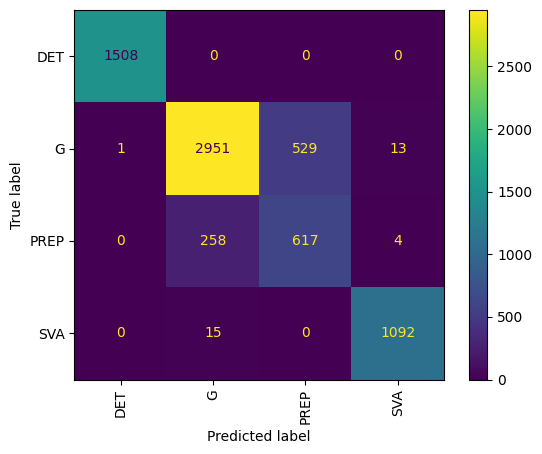

In [ ]:
model_bb_path = '/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/fine_tuned_BB_RoBERTa_model'

preds_bb, probs_bb = predict_model(model_bb_path, test_data)
# report = classification_report_f0_5(test_df.labels.tolist(), preds) #, output_dict=True)
target_names = ['DET', 'G', 'PREP','SVA']
# target_names = ['G', 'PREP', 'DET','SVA']
report_bb, cf_matrix_bb = fine_tune_eval(gold_labels, preds_bb, target_names)
df_bb = save_model_preds(test_df, preds_bb, probs_bb, outfile_path, 'bb_RoBERTa')